## Part 2

In this part of the project, you will compare the output of two linguistic processing libraries (e.g., Stanza vs. Spacy). Using a given set
of texts, you will run both libraries on these texts and report statistics
on how often they (dis)agree with respect to the task of named entity
recognition. For ease of comparison, ensure that both pipelines use
the same tokenization.

2. Named Entity Recognition: analysis by entity type (15 points)
• Write a function that checks one document (i.e. a biography) for
the following:

(a) the number of spans (i.e. token(s)) where both packages agree
and predict is an NE (i.e. complete overlap in span predicted).

(b) the number of spans where there is a partial agreement between
both packages (i.e. partial overlap in spans predicted).

(c) for each package, the number of spans that a package predicted
as an NE, but the other package did not predict as an NE.

(d) for the spans with full and partial agreement, was there an
agreement in the NE type (e.g. Person, Location, Organisation
etc)

(e) Use visualisation to compare the above statistics, per category
per package (i.e. Spacy vs Stanza)

Download libraries

In [3]:
import os
import spacy
import stanza
import pandas as pd
import matplotlib.pyplot as plt

Pre-tokenize the text

In [4]:
def tokenize_text(text):
    """
    Tokenizes input text into a list of tokens.
    """
    return text.split()

Reading biographies one by one (in order to save memory)

In [5]:
def read_biographies(folder_path):
    """
    Reads text files from a specified folder. 
    Biographies are categorized based on the suffix of their file names (e.g., '_category.txt').
    stores them in a dictionary categorized by their respective categories.
    """
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            category = filename.split("_")[-1].split(".")[0]
            name = "_".join(filename.split("_")[:-1])
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                text = file.read()
            yield name, category, text

Spacy pipeline

In [6]:
nlp_spacy = spacy.load("en_core_web_sm")

def extract_entities_spacy(text_tokens):
    """
    Extracts named entities using spacy's NER from a list of text tokens.
    Returns a list of tuples.
    Each tuple contains: Start and end character indices of the extracted namd entity, the text of the entity and the label of the entity.
    """
    doc = nlp_spacy(" ".join(text_tokens))  # Join tokens into a single string
    entities = []
    for ent in doc.ents:
        entities.append((ent.start_char, ent.end_char, ent.text, ent.label_))
    return entities


Stanza pipeline

In [7]:

stanza.download('en')
nlp_stanza = stanza.Pipeline('en', processors='tokenize,ner', tokenize_pretokenized=True)


def extract_entities_stanza(text_tokens):
    """
    Extracts named entities using Stanza's NER from a list of text tokens.
    Returns a list of tuples.
    Each tuple contains: Start and end character indices of the extracted namd entity, the text of the entity and the type of the entity.
    """
    doc = nlp_stanza(" ".join(text_tokens))  # Join tokens into a single string
    entities = []
    for ent in doc.entities:
        entities.append((ent.start_char, ent.end_char, ent.text, ent.type))
    return entities

2024-06-15 10:20:44 INFO: Downloaded file to C:\Users\Ahana\stanza_resources\resources.json
2024-06-15 10:20:44 INFO: Downloading default packages for language: en (English) ...
2024-06-15 10:20:45 INFO: File exists: C:\Users\Ahana\stanza_resources\en\default.zip
2024-06-15 10:20:47 INFO: Finished downloading models and saved to C:\Users\Ahana\stanza_resources
2024-06-15 10:20:47 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-06-15 10:20:47 INFO: Downloaded file to C:\Users\Ahana\stanza_resources\resources.json
2024-06-15 10:20:48 INFO: Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| ner       | ontonotes-ww-multi_charlm |

2024-06-15 10:20:48 INFO: Using device: cpu
2024-06-15 10:20:48 INFO: Loading: tokenize
2024-06-15 10:20:48 INFO: Loading: ner
2024-06-15 10:20:48 INFO: Done loading processors!


Compare entities

In [8]:
def compare_entities(entities_spacy, entities_stanza):
    """
    Compares named entities extracted by spaCy and Stanza. 
    Calculates various metrics of agreement between them.
    Returns a dictionary containing several comparison metrics which include counts of fully identical entities, partially overlapping entities, entities unique to spacy or Stanza, and instances where entity types (or labels) match.
    """
    full_agreement = 0
    partial_agreement = 0
    spacy_only = 0
    stanza_only = 0
    full_agreement_type_match = 0
    partial_agreement_type_match = 0

    spacy_set = set([(start, end) for start, end, text, label in entities_spacy])
    stanza_set = set([(start, end) for start, end, text, label in entities_stanza])

    # Check full agreement
    for ent in spacy_set.intersection(stanza_set):
        full_agreement += 1
        spacy_type = [label for start, end, text, label in entities_spacy if (start, end) == ent][0]
        stanza_type = [label for start, end, text, label in entities_stanza if (start, end) == ent][0]
        if spacy_type == stanza_type:
            full_agreement_type_match += 1

    # Check partial agreement
    for spacy_ent in entities_spacy:
        for stanza_ent in entities_stanza:
            spacy_start, spacy_end, spacy_text, spacy_label = spacy_ent
            stanza_start, stanza_end, stanza_text, stanza_label = stanza_ent
            if (spacy_start < stanza_end and spacy_end > stanza_start and 
                (spacy_start, spacy_end) != (stanza_start, stanza_end)):
                partial_agreement += 1
                if spacy_label == stanza_label:
                    partial_agreement_type_match += 1

    # Check spacy only and stanza only
    spacy_only = len(spacy_set - stanza_set)
    stanza_only = len(stanza_set - spacy_set)

    return {
        'full_agreement': full_agreement,
        'partial_agreement': partial_agreement,
        'spacy_only': spacy_only,
        'stanza_only': stanza_only,
        'full_agreement_type_match': full_agreement_type_match,
        'partial_agreement_type_match': partial_agreement_type_match
    }

Process and compare biographies

In [9]:
def process_and_compare_biographies(folder_path):
    """
    Calls the previous functions meants for tokenizing text and for ptocessing tokens by Spacy and Stanza.
    Then calls the function meant for comparing extracted entities.
    Returns a dataset that contains as columns all the metrics obtained before and adds to that two more columns named 'name' (person's name) and 'category'(computer scientist or sculptor).
    """
    data = []
    for name, category, text in read_biographies(folder_path):
        text_tokens = tokenize_text(text)
        entities_spacy = extract_entities_spacy(text_tokens)
        entities_stanza = extract_entities_stanza(text_tokens)
        
        # print(f"Entities extracted by spaCy for {name}: {entities_spacy}")
        # print(f"Entities extracted by Stanza for {name}: {entities_stanza}")
        
        comparison = compare_entities(entities_spacy, entities_stanza)
        comparison.update({
            'name': name,
            'category': category
        })
        data.append(comparison)
    
    df = pd.DataFrame(data)
    return df

Calculate and visualize statistics

In [10]:
def ensure_numeric(df, columns):
    """
    Converts specified columns in a pandas dataframe to numeric data type.
    """
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

def calculate_and_visualize_statistics(df):
    """
    Calculate average statistics per category from a dataframe and visualize them using bar plots.
    Generates of separate bar plots for each numeric metric.
    Filters unwanted categories ('links' here).
    """
    # Ensure numeric types for aggregation
    numeric_columns = ['full_agreement', 'partial_agreement', 'spacy_only', 'stanza_only', 'full_agreement_type_match', 'partial_agreement_type_match']
    ensure_numeric(df, numeric_columns)
    
    # Filter out unwanted categories
    unwanted_categories = ['links']
    df = df[~df['category'].isin(unwanted_categories)]
    
    stats = df.groupby('category')[numeric_columns].mean().reset_index()
    
    # Plotting
    categories = stats['category'].unique()
    metrics = numeric_columns

    for metric in metrics:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(stats['category'], stats[metric], color='skyblue')
        ax.set_title(f'Average {metric} per Category')
        ax.set_xlabel('Category')
        ax.set_ylabel(metric)
        plt.xticks(rotation=45)
        plt.show()

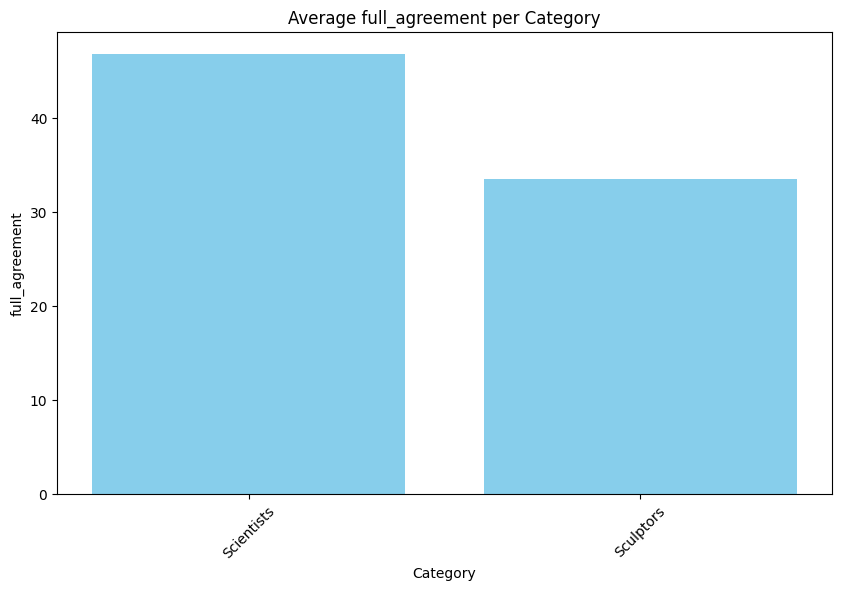

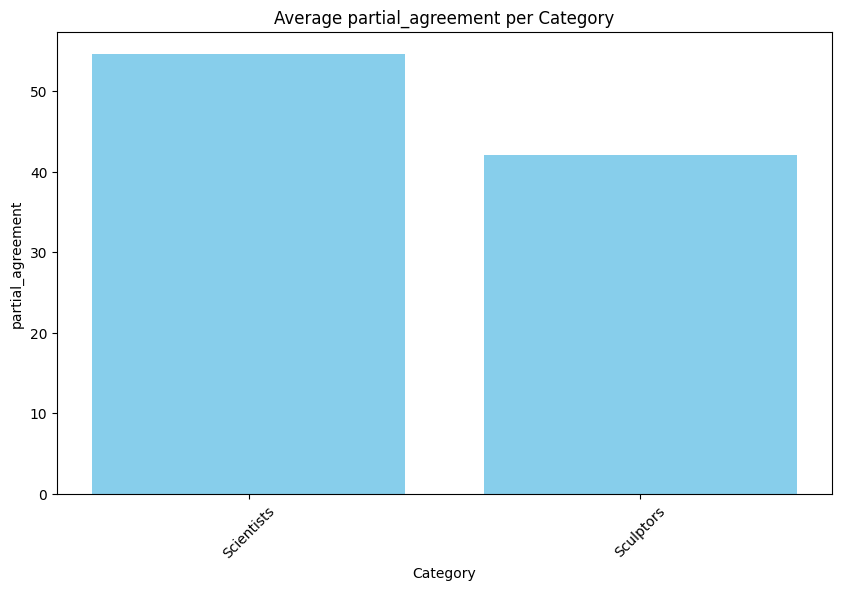

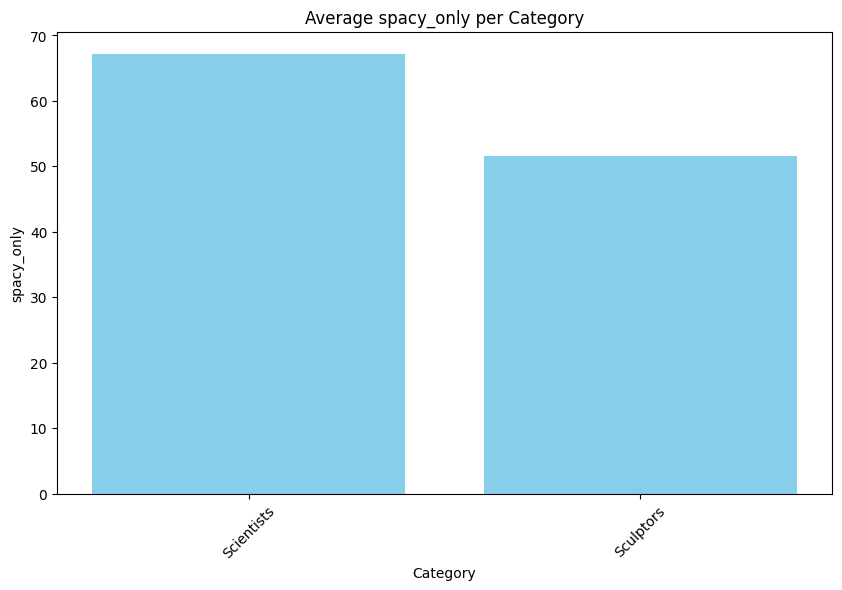

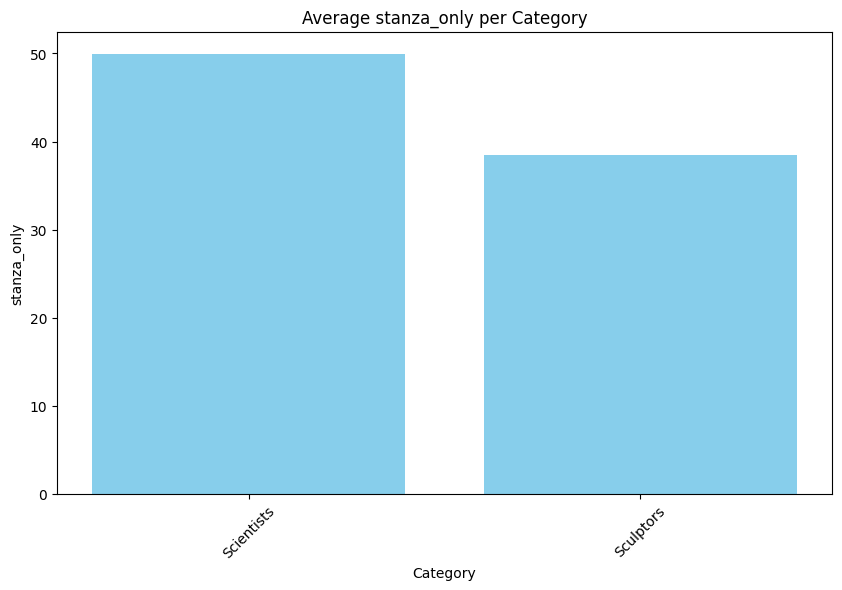

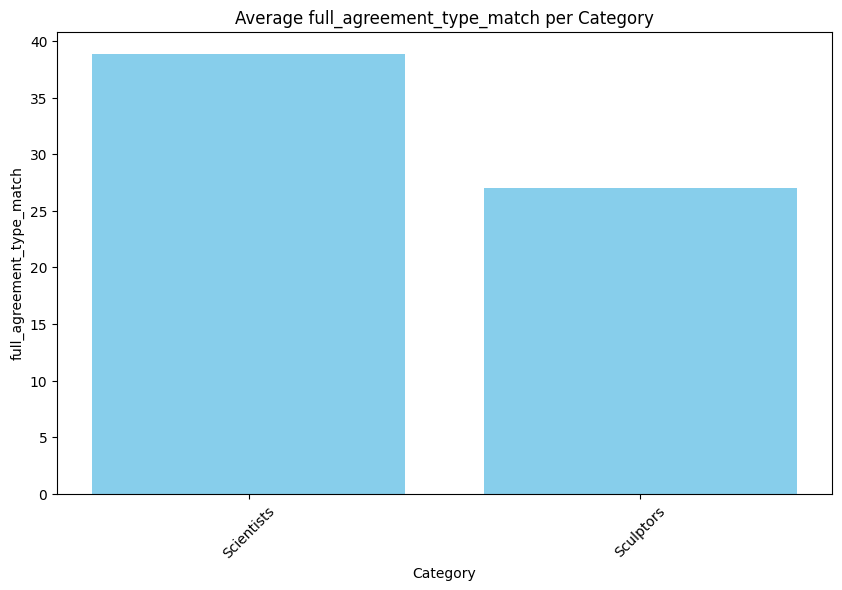

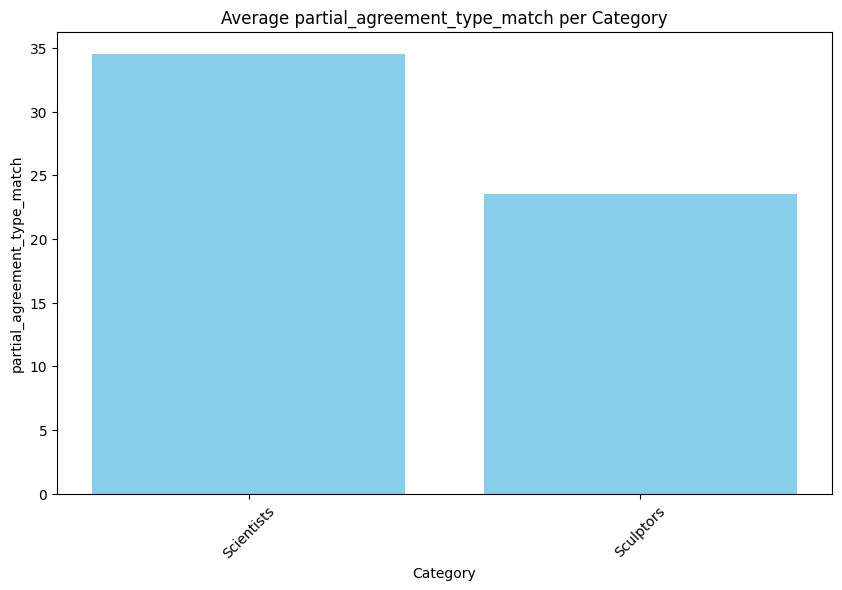

In [11]:
folder_path = rf"C:\Users\Ahana\OneDrive\Desktop\Project\Project"  
df = process_and_compare_biographies(folder_path)
calculate_and_visualize_statistics(df)
